In [1]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from keras.applications import *
from keras.preprocessing.image import *

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from glob import glob
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import *

import multiprocessing
from multiprocessing.dummy import Pool

%matplotlib inline

from IPython.display import *

def show(img):
    cv2.imwrite('test.jpg', img)
    display(Image('test.jpg'))

Using TensorFlow backend.


In [2]:
width = 299
height = width

fnames = glob('*_crop/*.png')
np.random.shuffle(fnames)
class0 = len(glob('normal_crop/*.png'))
class1 = len(glob('abnormal_crop/*.png'))

n = len(fnames)

X = np.zeros((n, height, width, 3), dtype=np.uint8)
y = np.zeros((n, 1), dtype=np.uint8)

def f(index):
    return index, cv2.imread(fnames[index])

with Pool(multiprocessing.cpu_count()) as pool:
    with tqdm(pool.imap_unordered(f, range(n)), total=n) as pbar:
        for i, img in pbar:
            X[i] = img
            if 'abnormal' in fnames[i]:
                y[i] = 1
            else:
                y[i] = 0

100%|██████████| 2287/2287 [00:00<00:00, 3343.22it/s]


In [3]:
input_tensor = Input((height, width, 3))

x = Lambda(inception_resnet_v2.preprocess_input)(input_tensor)

base_model = InceptionResNetV2(include_top=False, input_tensor=x)
x = base_model.output

x = GlobalAvgPool2D()(x)
x = Dense(1, activation='sigmoid')(x)
small_model = Model(input_tensor, x)
small_model.load_weights('irv2.h5')

In [4]:
input_tensor = Input((height*2, width*2, 3))

x = Lambda(inception_resnet_v2.preprocess_input)(input_tensor)

base_model = InceptionResNetV2(include_top=False, input_tensor=x)
x = base_model.output

x = AveragePooling2D((8, 8))(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
model.load_weights('irv2.h5')

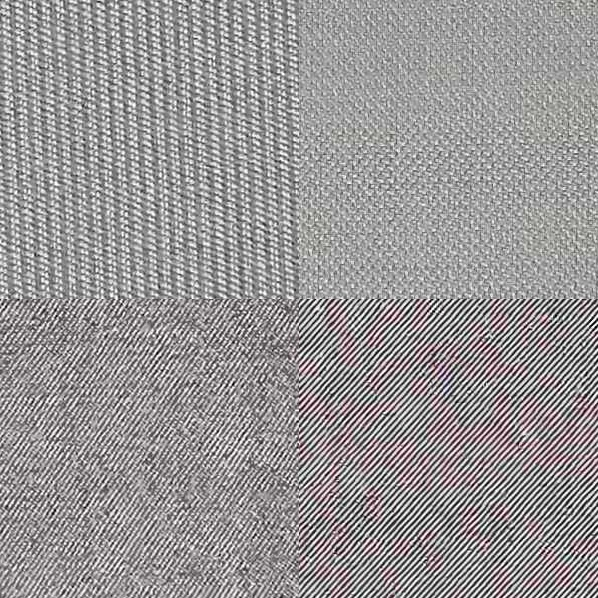

[[0 0]
 [0 0]]


In [5]:
A = np.zeros((height*2, width*2, 3))
A[:height, :width] = X[0]
A[height:, :width] = X[1]
A[:height, width:] = X[2]
A[height:, width:] = X[3]
show(A)
print(y[:4].reshape(2, 2).T)

In [8]:
small_model.predict(X[:4])

array([[0.00396636],
       [0.03519297],
       [0.0022155 ],
       [0.16453107]], dtype=float32)

In [9]:
model.predict(np.expand_dims(A, 0))[0,:,:,0]

array([[0.5723196, 0.9937084],
       [0.9998667, 0.9999999]], dtype=float32)